### Naive Bayes Classifier for Digit Recognition (35%)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
from sklearn.datasets import load_digits
mnist = load_digits()
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)



# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]

data shape:  (1797, 64)
label shape: (1797,)


### A. Create a 10x10 grid to visualize 10 examples of each digit.

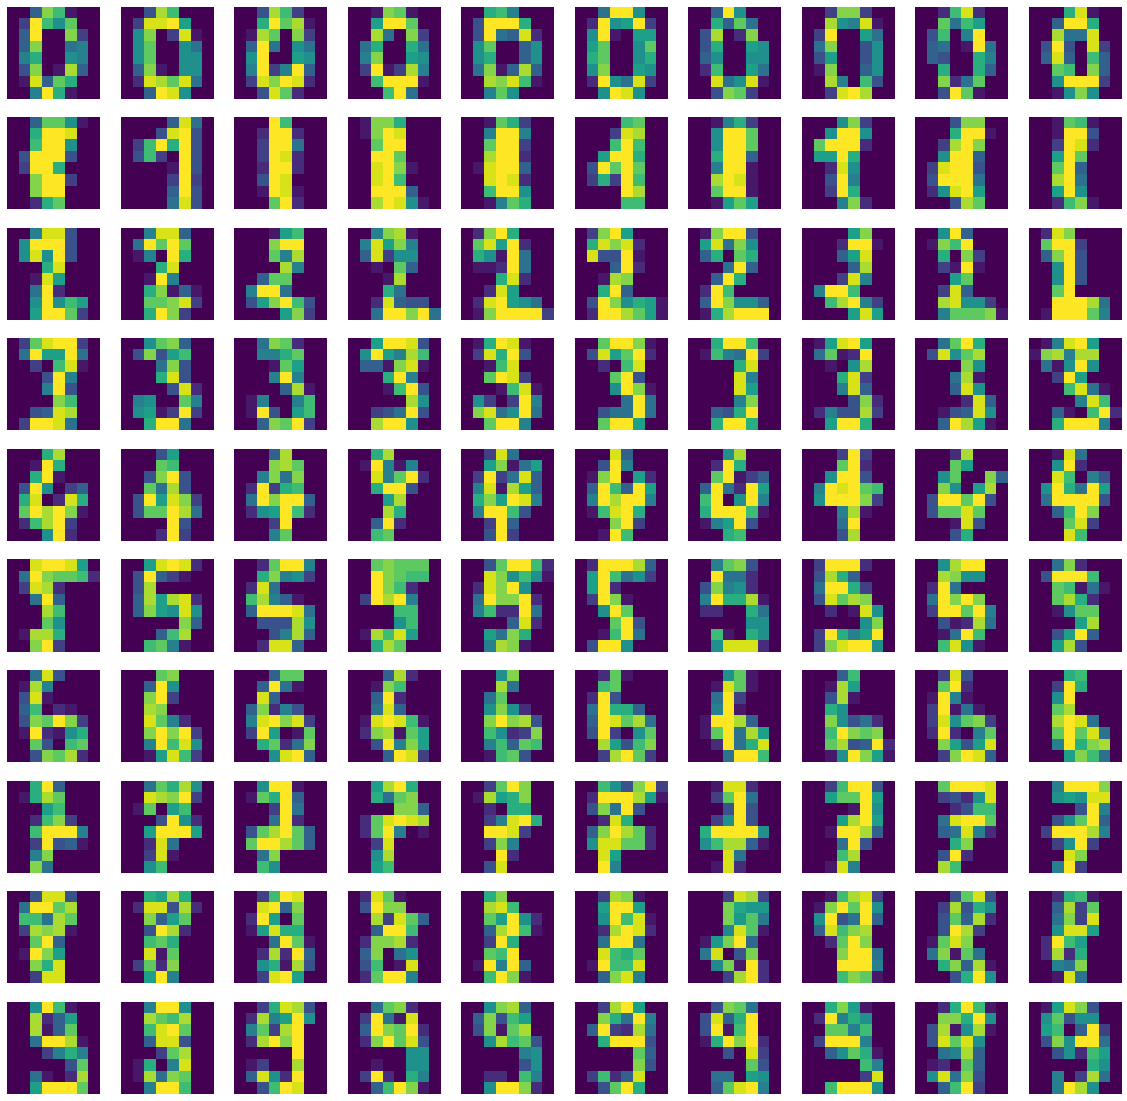

In [131]:
labels = np.unique(Y)
num_labels = 10
image_size = int(np.sqrt(X.shape[1]))

fig, axs = plt.subplots(len(labels), num_labels, figsize=(20,20))

for i,label in enumerate(labels):
    for j in range(num_labels):
        axs[i,j].imshow(X[Y==label][j].reshape((image_size,image_size)))
        axs[i,j].axis('off')

### B.  Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?
### Note, the answers may vary depending on what thresholds you set.

In [4]:
vectorisation = np.vectorize(int)
def binarize_image(image_array):
    return vectorisation(image_array>0)

In [5]:
def bin_image(image_array,thresholds = [0,0.5]):
    return vectorisation(image_array>thresholds[0])+vectorisation(image_array>thresholds[1])

# Bernoulli Naive Bayes model

In [6]:
binarized_train = binarize_image(mini_train_data)
binarized_dev_data = binarize_image(dev_data)
Bernoulli_model = BernoulliNB()
Bernoulli_model.fit(binarized_train, mini_train_labels)
Bernoulli_result = classification_report(Bernoulli_model.predict(binarized_dev_data), dev_labels, labels=list(range(10)))
print("The results of the Bernoulli Naive Bayes model trained on the binarized black and white train data:")
print(Bernoulli_result)   

The results of the Bernoulli Naive Bayes model trained on the binarized black and white train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.81      1.00      0.90        13
           2       0.73      1.00      0.84         8
           3       0.87      0.76      0.81        17
           4       1.00      0.71      0.83        14
           5       0.91      0.83      0.87        12
           6       1.00      1.00      1.00        15
           7       0.85      1.00      0.92        11
           8       1.00      0.50      0.67        18
           9       0.58      1.00      0.73        11

    accuracy                           0.86       140
   macro avg       0.87      0.88      0.86       140
weighted avg       0.90      0.86      0.86       140



# Multinomial Naive Bayes model

In [7]:
grey_threshold = np.median(mini_train_data[mini_train_data > 0])
binned_train_data = bin_image(mini_train_data, thresholds=[0, grey_threshold])
binned_dev_data = bin_image(dev_data)
Multinomial_model = MultinomialNB()
Multinomial_model.fit(binned_train_data, mini_train_labels)
Multinomial_result = classification_report(Multinomial_model.predict(binned_dev_data), dev_labels, labels=list(range(10)))
print("The results of the Multinomial Naive Bayes model trained on the binarized black, grey and white train data::")
print(Multinomial_result)

The results of the Multinomial Naive Bayes model trained on the binarized black, grey and white train data::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.62      0.91      0.74        11
           2       0.55      1.00      0.71         6
           3       0.87      0.76      0.81        17
           4       1.00      0.83      0.91        12
           5       0.82      0.90      0.86        10
           6       1.00      1.00      1.00        15
           7       0.92      0.86      0.89        14
           8       1.00      0.45      0.62        20
           9       0.63      0.86      0.73        14

    accuracy                           0.84       140
   macro avg       0.84      0.86      0.83       140
weighted avg       0.88      0.84      0.83       140



Comparing the performance of the BernoulliNB classifier on binarized data to the MultinomialNB classifier on binned data, we observe that the former performs slightly better with an accuracy of around 0.86 on the dev data, while the latter yields an accuracy of around 0.84.

Nevertheless, the difference in their performances is marginal, and the choice between them might depend on other factors like computational efficiency or ease of interpretation.

### C. Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Could you explain why?

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB(var_smoothing=20)
gnb.fit(mini_train_data, mini_train_labels)
dev_preds = gnb.predict(dev_data)
accuracy = accuracy_score(dev_labels, dev_preds)
print("Dev set accuracy:", accuracy)

Dev set accuracy: 0.5571428571428572


I trained the GaussianNB model on the mini training set and tested it on the dev set. The overall accuracy obtained was 0.55, which is considerably lower than the accuracies achieved by the BernoulliNB and MultinomialNB models, which were 0.86 and 0.84, respectively. 

These results confirm that the GaussianNB model is not appropriate for this dataset due to the binary nature of the features. The model assumes a normal distribution for the features and tries to model the probability distribution of each class using a Gaussian function. However, since the features in the digit dataset are binary, the model's underlying assumption is not valid, resulting in subpar performance. Hence, the BernoulliNB and MultinomialNB models, which are better suited for binary features, outperform the GaussianNB model in this dataset